In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow import one_hot
import numpy as np
from sklearn.preprocessing import MinMaxScaler

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.3) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
df = pd.read_csv('/Users/manikmukherjee/OneDrive - The Pennsylvania State University/semester 6/DS 440/PRJ-2301/D1. Building Assessments/building data.csv')

In [25]:
# df.head()

In [3]:
df1 = df.drop(['ObjectID', 'GlobalID', 'CreationDate','EditDate','Date of survey','Size of stilts (in.)','High water mark location (in.)','Number of stilts',"Other - MHU size","Roof Type Comments","Foundation Type Comments","Other - MHU Foundation Type",'Time of survey','Additional Comments','Building Type Comments'], axis=1).iloc[:,1:]

In [27]:
# df1.head()

In [4]:
new1 = pd.get_dummies(df1["Building Type"])
new2 = df1["SBE Foundation Type"].str.get_dummies(sep=',')

# for this maybe just put in a 1 if it is not an NAN and a 0 if NAN??
df1["Other - SBE Foundation Type"].str.get_dummies(sep=',')

new4 = df1["MHU Foundation Type"].str.get_dummies(sep=',')
new5 = df1["Roof Type"].str.get_dummies(sep=',')

# maybe just 1 or 0 again? 
df1["Other - Roof Type"].str.get_dummies(sep=',')

new7 = df1["MHU size"].str.get_dummies(sep=',')

df2 = pd.concat([df1, new1, new2, new4, new5, new7], axis=1)
df2 = df2.drop(['Building Type', 'SBE Foundation Type', 'Other - SBE Foundation Type', 'MHU Foundation Type', 'Roof Type','Other - Roof Type','MHU size'],axis=1)

def count(x):
    return len(str(x).split(','))

df2["Visible Damaged Components"] = df2["Visible Damaged Components"].apply(lambda x: count(x))
df2['Damage State Comments'] = df2['Damage State Comments'].apply(lambda x: len(str(x)))

# add random column to test as a null hypothesis

df2['rand_features'] = np.random.randn(len(df2))

In [7]:
df.columns

Index(['ObjectID', 'GlobalID', 'CreationDate', 'EditDate', 'Date of survey',
       'Time of survey', 'Surveyor Name(s) ', 'Building Type',
       'Building Type Comments', 'SBE Foundation Type',
       'Other - SBE Foundation Type', 'MHU Foundation Type',
       'Other - MHU Foundation Type', 'Foundation Type Comments',
       'Number of above ground stories', 'Roof Type', 'Other - Roof Type',
       'Roof Type Comments', 'MHU size', 'Other - MHU size',
       'Additional Comments',
       'Elevation of lowest horizontal structural component (in.)',
       'Size of stilts (in.)', 'Number of stilts',
       'High water mark location (in.)', 'Damage State',
       'Visible Damaged Components', 'Damage State Comments', 'Longitude',
       'Latitude'],
      dtype='object')

In [50]:
# import geopandas as gpd
# from shapely.geometry import Point, Polygon

# street_map = gpd.read_file('/Users/manikmukherjee/OneDrive - The Pennsylvania State University/semester 6/DS 440/tl_2016_12_cousub/tl_2016_12_cousub.shp')
# geometry = [Point(xy) for xy in zip(df["Longitude"], df["Latitude"])]

# new = gpd.GeoDataFrame(geometry,columns=['geometry'])
# new.crs = "EPSG:2238"
# new.to_crs(epsg=2238, inplace=True)

# street_map.crs = "EPSG:2238"
# street_map.to_crs(epsg=2238, inplace=True)

# #find distance from all of the points to the shapfile in meters
# df2['dist_from_shore'] = new.geometry.apply(lambda x: street_map.distance(x).min())

In [5]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

street_map = gpd.read_file('/Users/manikmukherjee/Downloads/cb_2018_us_state_500k/cb_2018_us_state_500k.shp')
geometry = [Point(xy) for xy in zip(df["Longitude"], df["Latitude"])]

new = gpd.GeoDataFrame(geometry,columns=['geometry'])
new.crs = "EPSG:2238"
new.to_crs(epsg=2238, inplace=True)

street_map = street_map.iloc[9,:]
street_map = gpd.GeoSeries(street_map.geometry)

#find distance from all of the points to the shapfile in meters
df2['dist_from_shore'] = new.geometry.apply(lambda x: street_map.boundary.distance(x))

In [53]:
df2['dist_from_shore'].to_csv('michael distance from shore.csv')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [6]:
df2 = df2.dropna(subset=['Damage State'])
df2 = df2.fillna(0)
x, y = df2.drop(['Damage State'],axis=1), one_hot(df2['Damage State'],5)

In [7]:
x_scaled = MinMaxScaler().fit_transform(x)

In [8]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(x_scaled,y)

importances = list(zip(x.columns,clf.feature_importances_))
feature_importances = pd.DataFrame(importances,columns=['name','importance'])
feature_importances.sort_values(by=['importance'],ascending=False)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,name,importance
2,Visible Damaged Components,0.151648
5,Latitude,0.148884
30,dist_from_shore,0.136423
4,Longitude,0.113081
29,rand_features,0.111516
1,Elevation of lowest horizontal structural comp...,0.107005
3,Damage State Comments,0.053243
17,engineered_anchorage_devices,0.020255
16,chassis_system,0.019205
21,Gable,0.017701


In [13]:
feature_plot = feature_importances[feature_importances['importance'] > .09] 

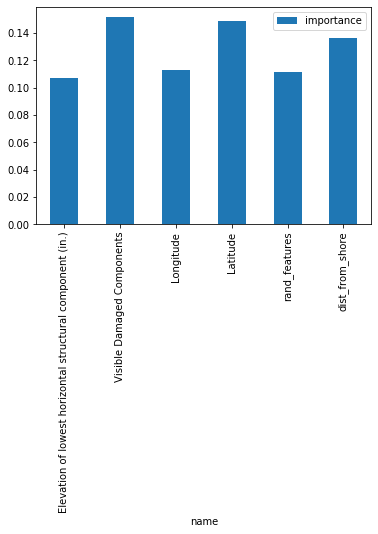

In [15]:
plot = feature_plot.plot.bar(x='name',y='importance')
plot.get_figure().savefig('michael imoprtances.png')

In [9]:
# from matplotlib import pyplot as plt
# from sklearn import tree

# # for tree_in_forest in clf.estimators_:
# plt.figure(figsize=(20,20))
# _ = tree.plot_tree(clf.estimators_[0],
#                feature_names = x.columns,
#                filled = True)

X Make a random column to test for statistical significance

maybe don't use visible damaged components because they don't have this information.  Generally try to figure out features that could be used BEFORE going to the house.  Look at footprint of structure, how many houses between this and coastline, housing density?

X look at distance from shore possibly using shape files?

X probabilities of being in a damage state

X Normalize the dataframe so as not to give any features an advantage